This is the start of my final Social Media Data Analysis project. I will be looking at how collective memory is seen in the digital world. This is based on a paper entitled 'The memory remains: Understanding collective memory in the digital age' (https://www.science.org/doi/full/10.1126/sciadv.1602368), which looked at how Wikipedia page view counts increase for pages about air disasters after similar incidents. I will be looking at how Wikipedia and Procyclingstats, a website about all professional road cycling races, teams, and riders, has a similar effect on rider pages when a fatality occurs. 

Imports

In [45]:
# all of my imports
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re 
from plotnine import *
import math
from dateutil.relativedelta import relativedelta

Collection of a list of pro cyclists who died either in race or in training. This list does not include former professional riders who died while cycling or otherwise, for example former pros who died from illness, suicide, or road accidents. For one, that list is not on Wikipedia. For two, the exclusion criteria are much harder to identify. A former rider who died at the age of 90 and belonging to a very different era of cycling will not be looked upon the same as a current professional or one who was recently retired. Such a project would need a much larger scale. 

In [3]:
# scrape list of cyclists who died from Wikipedia as starting point
url_list = "https://en.wikipedia.org/wiki/List_of_racing_cyclists_and_pacemakers_with_a_cycling-related_death"
headers = {"user-agent": "Mozilla/5.0 (X11; CrOS x86_64 14816.131.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
resp_list = requests.get(url_list, headers=headers)
soup_list = BeautifulSoup(resp_list.content, 'html.parser')

# turn strings into dates
def string_to_date(string):
    # all the possible date formats
    for format in ("%B %d, %Y", '%Y', "%B %Y"):
        try:
            return datetime.strptime(string.strip().split("[", 1)[0], format).date()
        except ValueError:
            pass
    raise ValueError("Date format invalid")


cyclists_list = []

# multiple tables in Wikipedia page
for tables in range(0, len(soup_list.findAll('tbody'))):
    table = soup_list.findAll("tbody")[tables].findAll('tr')
    for row in range(1, len(table)):
        row = table[row].text.strip().splitlines()
        # print(row)
        # print("Name:" + re.sub(" \[.*\]", "", row[0])) 
        # different table formats in the Wikipedia page
        if (row[2] == "" or row[2] == "—" or row[2] == "-") and row[3] == '':
            # extra box after image
            # print(f"Status: {row[4]} Date of death: {string_to_date(row[6])} Nationality: {row[8]}")
            row_dict = {"Name" : re.sub(r'\s+', ' ',re.sub("\[.*\]", "", row[0])).strip(), "Competitive Status": row[4], "Date of death": string_to_date(row[6]), "Nationality": re.sub("^.*?([A-Z])", "\\1",row[8]), "Race death": 0}
        elif row[2] == "—" or row[2] == "" or row[2] == "-":
            # regular condition
            # print(f"Status: {row[3]} Date of death: {string_to_date(row[5])} Nationality: {row[7]}")
            row_dict = {"Name" : re.sub(r'\s+', ' ',re.sub("\[.*\]", "", row[0])).strip(), "Competitive Status": row[3], "Date of death": string_to_date(row[5]), "Nationality": re.sub("^.*?([A-Z])", "\\1",row[7]), "Race death": 0}
        else:
            # when the image box is empty
            # print(f"Status: {row[2]} Date of death: {string_to_date(row[4])} Nationality: {row[6]}")
            row_dict = {"Name" : re.sub(r'\s+', ' ',re.sub("\[.*\]", "", row[0])).strip(), "Competitive Status": row[2], "Date of death": string_to_date(row[4]), "Nationality": re.sub("^.*?([A-Z])", "\\1",row[6]), "Race death": 0}
        # first table is just race deaths
        if tables == 0:
            row_dict["Race death"] = 1
        cyclists_list.append(row_dict)
        # print(row[9])

cyclists = pd.DataFrame.from_dict(cyclists_list)
cyclists = cyclists.loc[cyclists['Date of death'] > datetime.strptime('1980-01-01', '%Y-%m-%d').date()]


# My own personal list of either riders who are not on the list or who I have readded after date of death exclusion 
# (Juan Manuel Santisteban died at the Giro, Jean-Pierre Monseré died while WC, Tom Simpson famous death on Mont Ventoux, Richard Depoorter died during the Tour de Suisse, Francisco Cepeda died during the Tour, Ottavio Bottecchia former Tour winner)
more_cyclists = pd.DataFrame({"Name": ["Gabriele Glodenyte", "Clément Ouimet", "John Cornish", "Kelly Catlin", "Lieuwe Westra", "Raul Garcia Alvarez", "Michael Antonelli", "Jason Lowndes", "Vicente López Carril", "Marc Demeyer", "Bert Oosterbosch", "Joachim Halupczok", "Stive Vermaut", "Rob Goris", "Niels De Vriendt", "Eslam Nasser Zaki", "Rab Wardell", 'Jacopo Venzo', "Magnus White", "Chris Anker Sørensen", "Connor Lambert", "Ethan Boyes", "Arturo Gravalos", "Moriah Wilson", "Davide Rebellin", 'Juan Manuel Santisteban', "Jean-Pierre Monseré", "Tom Simpson", "Richard Depoorter", "Stan Ockers", 'Francisco Cepeda', 'Ottavio Bottecchia']}, columns=cyclists.columns)

cyclists = pd.concat([cyclists, more_cyclists]).reset_index(drop=True)
cyclists.to_csv("/home/ubuntu/Konstanz/SDMA/project/cyclists_wiki.csv")

This is to collect all the personal information of the riders from procyclingstats

In [32]:
#procyclingstats scraping

headers = {"user-agent": "Mozilla/5.0 (X11; CrOS x86_64 14816.131.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}

pcs_dicts = []

# getting all the extra information for each cyclist
for rider in list(cyclists["Name"]):
    print(rider)
    url = f'https://www.procyclingstats.com/rider/{re.sub(r" +", "-", rider.strip())}'
    # print(url)
    resp = requests.get(url, headers=headers)
    # print('resp found')
    soup = BeautifulSoup(resp.content, 'html.parser')
    # print("soup found")
    # as long as it's not a non-existent page
    if soup.find(class_ = 'main').text != 'Page not found':
        # print("Page found")
        info = soup.find(class_ = "rdr-info-cont").text
        # print("Found info")
        if (re.search(r'(\d{1,2}(st|nd|rd|th) [A-Za-z]+ \d{4})', info) != "-" and re.search(r'(\d{1,2}(st|nd|rd|th) [A-Za-z]+ \d{4})', info) != None):
            birth_date = datetime.strptime(re.sub(r'\b(\d)\b', r'0\1 ', re.sub(r'(\d+)[A-Za-z]{2}\b', r'\1', re.search(r'(\d{1,2}(st|nd|rd|th) [A-Za-z]+ \d{4})', info).group(1))), '%d %B %Y').date() 
            # print('birth date')
            death_date = datetime.strptime(re.sub(r'\b(\d)\b', r'0\1 ', re.sub(r'(\d+)[A-Za-z]{2}\b', r'\1', re.findall(r'(\d{1,2}(st|nd|rd|th) [A-Za-z]+ \d{4})', info)[1][0])), '%d %B %Y').date() if len(re.findall(r'(\d{1,2}(st|nd|rd|th) [A-Za-z]+ \d{4})', info)) > 1 else np.nan
            # print('death')
            if type(death_date) != float:
                age = death_date.year - birth_date.year - 1 if birth_date.month > death_date.month or (birth_date.month == death_date.month and birth_date.day > death_date.day) else death_date.year-birth_date.year
            # print('age')
        psc_year_points = soup.find(class_='rdrResultsSum').find_all('b')[1].text
        nationality = re.findall(': [A-Z][^A-Z]*', info)[0][2:]
        # print("year points")
        teams = re.search(r'\(.*\)', soup.find(class_= re.compile(r'list rdr-teams.*')).text) if soup.find(class_= re.compile(r'list rdr-teams.*')).text != "" else "NA"
        team_level = teams.group()[1:-1] if (teams != None and type(teams) != str) else np.nan
    url_stats = f'https://www.procyclingstats.com/rider/{re.sub(r" +", "-", rider.strip())}/statistics/overview'
    resp_stats = requests.get(url_stats, headers=headers)
    soup_stats = BeautifulSoup(resp_stats.content, 'html.parser')
    # as long as it's not a non-existent page
    if soup_stats.find(class_ = 'main').text != 'Page not found' and soup_stats.find(class_ = 'sum') != None:
        # print("stats page")
        career_points = soup_stats.find(class_ = 'sum').find_all(class_='')[1].text
        # print("career points")
        career_wins = soup_stats.find(class_ = 'sum').find_all(class_='')[4].text
        # print("career wins")
        carrer_race_days = soup_stats.find(class_ = 'sum').find_all(class_='')[5].text
        # print("career race days")
        year_wins = soup_stats.find('tbody').find_all('td')[4].text if soup_stats.find('tbody').find_all('td')[4].text != '-' else 0
        # print("year wins")
        pcs_dicts.append({"Name": rider, "Date of birth": birth_date, "Date of death": death_date, "Nationality": nationality, "Age": age, "Year points": psc_year_points, "Career points": career_points, "Career wins": career_wins, "Career race days": carrer_race_days, "Year wins": year_wins, 'Team level': team_level})
#         # print(f"Rider: {rider}, URL: {url}, Name: {name}, Age: {age}, Year points: {psc_year_points}, Career points: {career_points}, Career wins: {career_wins}, Career race days: {carrer_race_days}, Year wins: {year_wins}")
pcs_cyclists = pd.DataFrame.from_dict(pcs_dicts)
cyclists = pd.read_csv("/home/ubuntu/Konstanz/SDMA/project/cyclists_wiki.csv")
full_cyclists = cyclists.merge(pcs_cyclists, on = "Name", how='outer')
full_cyclists['Date of death_x'] = full_cyclists['Date of death_x'].fillna(full_cyclists['Date of death_y'])
full_cyclists['Nationality_x'] = full_cyclists['Nationality_x'].fillna(full_cyclists['Nationality_y'])
full_cyclists = full_cyclists.rename(columns={'Date of death_x': 'Date of death', 'Nationality_x':'Nationality'})
full_cyclists = full_cyclists.drop(columns=['Date of death_y', 'Nationality_y'])
full_cyclists.to_csv('/home/ubuntu/Konstanz/SDMA/project/cyclists.csv')

Joaquim Agostinho


ValueError: invalid literal for int() with base 10: ''

Full csv of all cyclists initially considered for analysis

In [13]:
cyclists = pd.read_csv('/home/ubuntu/Konstanz/SDMA/project/cyclists.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).drop_duplicates(subset=['Name'], keep='first')

Merge together all the Wikipedia viewcount sources 

In [6]:
# wikipedia page view merging
# quick function for opening and formating dataframes
def format_csv(path=str):
    df = pd.read_csv(path)
    df.columns = df.columns.str.replace("\[en\]", "", regex=True)
    df.rename(columns = {'DateTime' : 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    return df
wikishark1 = format_csv("/home/ubuntu/Konstanz/SDMA/project/wikishark.csv")
wikishark2 = format_csv("/home/ubuntu/Konstanz/SDMA/project/wikishark_cont.csv")
wikishark3 = format_csv("/home/ubuntu/Konstanz/SDMA/project/wikishark_more_cont.csv")[:5734]
dr_wikishark = format_csv("/home/ubuntu/Konstanz/SDMA/project/Davide_Rebellin.csv")[:5734]
pageviews = format_csv('/home/ubuntu/Konstanz/SDMA/project/wiki_pageviews.csv')[['Date', 'Patricia Pepper', 'Adrián Babič', 'Germán Chaves', 'Tijl De Decker', 'Ethan Boyes', 'Arturo Grávalos']]
older_events = format_csv('/home/ubuntu/Konstanz/SDMA/project/older_events.csv')[:5734]

viewcount = wikishark1.merge(wikishark2).merge(wikishark3).merge(dr_wikishark).merge(pageviews, how = 'outer').merge(older_events)
viewcount.to_csv("/home/ubuntu/Konstanz/SDMA/project/viewcount.csv")

I don't have the events separated into 'source' and 'target' events quite the same like in the paper. I find that whenever a new tragedy occurs, I tend to think about the last one more than any other, so having events only in one group or another means that the interaction between much more recent events is lost. I therefore have all events from 2008 until the present as 'source' events as those are the ones where I have data from when the event occured and all events that are from 1980 onward and have Wikipedia pages are 'target' events.

In [47]:
viewcount = pd.read_csv("/home/ubuntu/Konstanz/SDMA/project/viewcount.csv", index_col=[0])
viewcount['Date'] = pd.to_datetime(viewcount['Date']).dt.date
# standardizing names of cyclists
viewcount.rename(columns = {'Mike Hall (cyclist)': 'Mike Hall', 'Víctor Cabedo': 'Victor Cabedo', 'Arturo Grávalos':'Arturo Gravalos', 'Francisco Cepeda (cyclist)': 'Francisco Cepeda'}, inplace = True)
cyclists = pd.read_csv("/home/ubuntu/Konstanz/SDMA/project/cyclists.csv", index_col=[0]).drop(columns='Unnamed: 0')
cyclists['Date of birth'] = pd.to_datetime(cyclists['Date of birth'], errors = 'coerce').dt.date
cyclists['Date of death'] = pd.to_datetime(cyclists['Date of death'], errors = 'coerce').dt.date
# manually adding dates of death for these three: Arturo Gravalos (101), Ethan Boyes(100), Sorenson(98)
cyclists.at[100, 'Date of death'] = datetime.strptime("04 April 2023", "%d %B %Y").date()
cyclists.at[101, 'Date of death'] = datetime.strptime("19 May 2023", '%d %B %Y').date()
cyclists.at[98, "Date of death"] = datetime.strptime("18 September 2021", '%d %B %Y').date()
# sort so that the algorithm runs faster in the next step
cyclists.sort_values(by = 'Date of death', inplace = True, ignore_index = True)

viewflow_list = []
# for each cylist with wikipedia viewcounts
for s_cyclist in list(viewcount.columns)[1:]:
    s_cyclist_dod = cyclists.at[cyclists.index[cyclists['Name'] == s_cyclist][0], 'Date of death'] 
    # check if date of death is after first view count, if dod before first view count then not source only target
    if s_cyclist_dod >= viewcount.at[viewcount[s_cyclist].first_valid_index(), 'Date']:
        # print('Source')
        # pair up with every target ie rider who died before current source
        for t_cyclist in list(viewcount.columns)[1:]:
            # print(t_cyclist)
            if cyclists.index[cyclists['Name'] == t_cyclist][0] < cyclists.index[cyclists['Name'] == s_cyclist][0]:
                t_first_vc = viewcount.at[viewcount[t_cyclist].first_valid_index(), 'Date']
                timeframe = viewcount.loc[(viewcount['Date'] >= t_first_vc) & (viewcount['Date'] < s_cyclist_dod - timedelta(days=1)), t_cyclist]
                mean_vc = timeframe.sum() / (s_cyclist_dod - t_first_vc - timedelta(days=1)).days
                vf_sum = max(viewcount.loc[(viewcount['Date'] >= s_cyclist_dod) & (viewcount['Date'] < s_cyclist_dod + timedelta(days=7)), t_cyclist].sum(), 
                             viewcount.loc[(viewcount['Date'] >= s_cyclist_dod - timedelta(days=1)) & (viewcount['Date'] < s_cyclist_dod + timedelta(days=6)), t_cyclist].sum())
                mean_vf = (vf_sum / 7) - mean_vc
                vf_median = max(viewcount.loc[(viewcount['Date'] >= s_cyclist_dod) & (viewcount['Date'] < s_cyclist_dod + timedelta(days=7)), t_cyclist].median(), 
                             viewcount.loc[(viewcount['Date'] >= s_cyclist_dod - timedelta(days=1)) & (viewcount['Date'] < s_cyclist_dod + timedelta(days=6)), t_cyclist].median())
                median_vf = vf_median - timeframe.median()
                mean_median_vf = (vf_sum / 7) - timeframe.median()
                target_date = cyclists.at[cyclists.index[cyclists['Name'] == t_cyclist][0], 'Date of death']
                years_diff = relativedelta(s_cyclist_dod, target_date).years
                # print(f'Source: {s_cyclist}, Target: {t_cyclist}, Date of death: {s_cyclist_dod}, Target first viewcount: {t_first_vc}, "Target date": {target_date}')
                # print(f'Mean VC: {mean_vc}, Mean VF: {vf_sum/7}, VF mean: {mean_vf}, VF median: {median_vf}, VF mean-median: {mean_median_vf}')#, Source: {s_cyclist}, Date of death: {s_cyclist_dod}, Target: {t_cyclist}, Target first VC: {t_first_vc}, Sum: {timeframe}, Av: {mean_vc}, VF sum: {vf_sum}')
                viewflow_list.append({"Source": s_cyclist, "Target": t_cyclist,"Viewflow_median": vf_median, "Viewflow_mean-median": mean_median_vf, 
                                      'Viewflow_log_median': math.log10(vf_median) if vf_median > 0 else 0 if vf_median == 0 else -math.log10(abs(vf_median)) if vf_median < 0 else np.nan, 
                                      "Viewflow_log_mean-median": math.log10(mean_median_vf) if mean_median_vf > 0 else 0 if mean_median_vf == 0 else -math.log10(abs(mean_median_vf)) if mean_median_vf < 0 else np.nan,
                                      'Source date': s_cyclist_dod, "Target date": cyclists.at[cyclists.index[cyclists['Name'] == t_cyclist][0], 'Date of death'], 'Years difference':years_diff, 
                                      'Mean target prior views': mean_vc, 'Median target prior views':timeframe.median()})
viewflow_df = pd.DataFrame.from_dict(viewflow_list)
viewflow_df.to_csv("/home/ubuntu/Konstanz/SDMA/project/viewflow.csv")

Joaquim Agostinho
Connie Meijer
Fabio Casartelli
Manuel Sanroma
Saúl Morales
Nicole Reinhart
Andrey Kivilev
Alessio Galletti
Isaac Gálvez
Bruno Neves
Wouter Weylandt
Junior Heffernan
Annefleur Kalvenhaar
Antoine Demoitié
Daan Myngheer
Gijs Verdick
Bahman Golbarnezhad
Mike Hall
Michael Goolaerts
Robbert de Greef
Bjorg Lambrecht
Suleiman Kangangi
Gino Mäder
Antonio Martín
Néstor Mora
Hernán Patiño
Ricardo Otxoa
Lauri Aus
Amy Gillett
Frederiek Nolf
Zinaida Stahurskaya
Jure Robič
Carla Swart
Carly Hibberd
Victor Cabedo
Iñaki Lejarreta
Burry Stander
Amy Dombroski
Kristof Goddaert
Kelly McGarry
Michele Scarponi
Jason Lowndes
Desiet Kidane
Marc Demeyer
Bert Oosterbosch
Stive Vermaut
Rob Goris
Joachim Halupczok
Vicente López Carril
Lieuwe Westra
Kelly Catlin
Chris Anker Sørensen
Davide Rebellin
Patricia Pepper
Adrián Babič
Germán Chaves
Tijl De Decker
Ethan Boyes
Arturo Gravalos
Tom Simpson
Juan Manuel Santisteban
Jean-Pierre Monseré
Stan Ockers
Richard Depoorter
Francisco Cepeda
Ottavio Botte

In [25]:
viewflow_df = pd.read_csv('/home/ubuntu/Konstanz/SDMA/project/viewflow.csv',index_col=[0])
# chronological for plots
chrono_viewflow = viewflow_df.sort_values(by = ['Source date', "Target date"])
event_order = chrono_viewflow['Source'].unique()[::-1]
chrono_viewflow['Source'] = pd.Categorical(chrono_viewflow['Source'], categories=event_order, ordered=True)
event_order = chrono_viewflow['Target'].unique()
chrono_viewflow['Target'] = pd.Categorical(chrono_viewflow['Target'], categories=event_order, ordered=True)
# longview for viewflow plots
viewcount_long = pd.melt(viewcount, id_vars=['Date'], var_name='Cyclist', value_name='Page views')
# selection for time series plot
ts_data = viewcount_long[viewcount_long['Cyclist'].isin(['Tom Simpson', 'Fabio Casartelli', 'Gino Mäder', 'Bjorg Lambrecht', 'Wouter Weylandt'])]
ts_data = ts_data[ts_data['Date'] >= pd.to_datetime('2019-06-01')]
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
breaks = pd.date_range(pd.to_datetime('2019-06-01'), ts_data['Date'].max(), freq='M')
#ts_data = ts_data.groupby('Cyclist')['Page views'].rolling(window=3).mean().reset_index()
min_vf = min(viewflow_df['Viewflow_log_mean-median'])
max_vf = max(viewflow_df['Viewflow_log_mean-median'])
# where is 0 for color scale
percentile_zero = (0 - min_vf) / (max_vf - min_vf)


# time series of selected cyclists in 4 year period
time_series_plot = (
    ggplot(ts_data, aes(x='Date', y='Page views', color = 'Cyclist', group = 'Cyclist')) +
    geom_line() +
    labs(title='Page Views of Select Target and Source Cyclists', subtitle= 'June 1, 2018 to September 12, 2023', x='Date', y='Page views (log)') +
    theme_minimal() +
    scale_y_log10() +
    scale_color_manual(values=['#ea5545', '#edbf33','#bdcf32', '#27aeef', '#b33dc6']) + 
    theme(figure_size=(12,7), plot_title=element_text(size=16, hjust=0.5), axis_text_x=element_text(rotation=45, hjust=1)) + 
    scale_x_datetime(breaks=breaks, date_labels='%b %Y') +
    annotate('text', x=pd.to_datetime('2019-08-05'), y = 20000, label='Bjorg Lambrecht\'s\ndeath') +
    annotate('text', x=pd.to_datetime('2023-06-16'), y = 35000, label='Gino Mäder\'s\ndeath')
    )

# show huge outliers
box_plot = (
    ggplot(viewcount_long) +
    geom_boxplot(aes(x='Cyclist', y='Page views')) +
    labs(title='Distribution of Page Views amongst Cyclist Death Wikipedia Pages', x='Cyclist', y='Page views (log)') +
    theme_minimal() +
    scale_y_log10() +
    theme(figure_size=(10, 6), plot_title=element_text(size=16, hjust=0.5), axis_text_x=element_text(rotation=45, hjust=1))
)

# viewflow plots
colors = ['#000000', '#FF0000']
mean_med_colors = ["#300042", '#000000', "#fd2929"]
log_median_viewflow_plot = (
    ggplot(chrono_viewflow, aes(x='Target', y='Source', fill='Viewflow_log_median')) +
    geom_tile() +
    labs(title='Viewflow of Cyclist Death Wikipedia Pages (Log Median)', x='Target', y='Source', fill='Viewflow\n(log median)') +
    # scale_fill_gradientn(colors=colors, values=[0, 1]) +  
    scale_fill_gradient(low='black', high='#29b8fd') +
    theme_minimal() +
    theme(figure_size=(12, 7), axis_text_x=element_text(angle=45, hjust=1))
)

log_mean_median_viewflow_plot = (
    ggplot(chrono_viewflow, aes(x='Target', y='Source', fill='Viewflow_log_mean-median')) +
    geom_tile() +
    labs(title='Viewflow of Cyclist Death Wikipedia Pages (Log Mean-Median)', x='Target', y='Source', fill='Viewflow\n(log mean-median)') +
    scale_fill_gradientn(colors=mean_med_colors, values=[0, percentile_zero, 1]) +  
    theme_minimal() +
    theme(figure_size=(12, 7), axis_text_x=element_text(angle=45, hjust=1))
)

# tried to see it but the scale of views is too large to see anything
median_viewflow_plot = (
    ggplot(chrono_viewflow, aes(x='Target', y='Source', fill='Viewflow_median')) +
    geom_tile() +
    labs(title='Viewflow', x='Target', y='Source', fill='Viewflow (median)') +
    scale_fill_gradientn(colors=colors, values=[0, 0.0000001, 1]) +  
    theme_minimal() +
    theme(figure_size=(12, 7), axis_text_x=element_text(angle=45, hjust=1))
)

# again tried it but the scales are so vastly different that any insights are lost
mean_median_viewflow_plot = (
    ggplot(chrono_viewflow, aes(x='Target', y='Source', fill='Viewflow_median')) +
    geom_tile() +
    labs(title='Viewflow', x='Target', y='Source', fill='Viewflow (median)') +
    scale_fill_gradientn(colors=colors, values=[0, 0.0000001, 1]) +  
    theme_minimal() +
    theme(figure_size=(12, 7), axis_text_x=element_text(angle=45, hjust=1))
)




# print(box_plot)
# print(log_median_viewflow_plot)
# print(log_mean_median_viewflow_plot)
# print(time_series_plot)


/tmp/ipykernel_435085/550364579.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


Based on the box and whisker plot, I've decided to use the median instead of the mean for the average page views for target events before a source event. This is because the distribution of the page views has a huge range, as there are lots of outliers. 

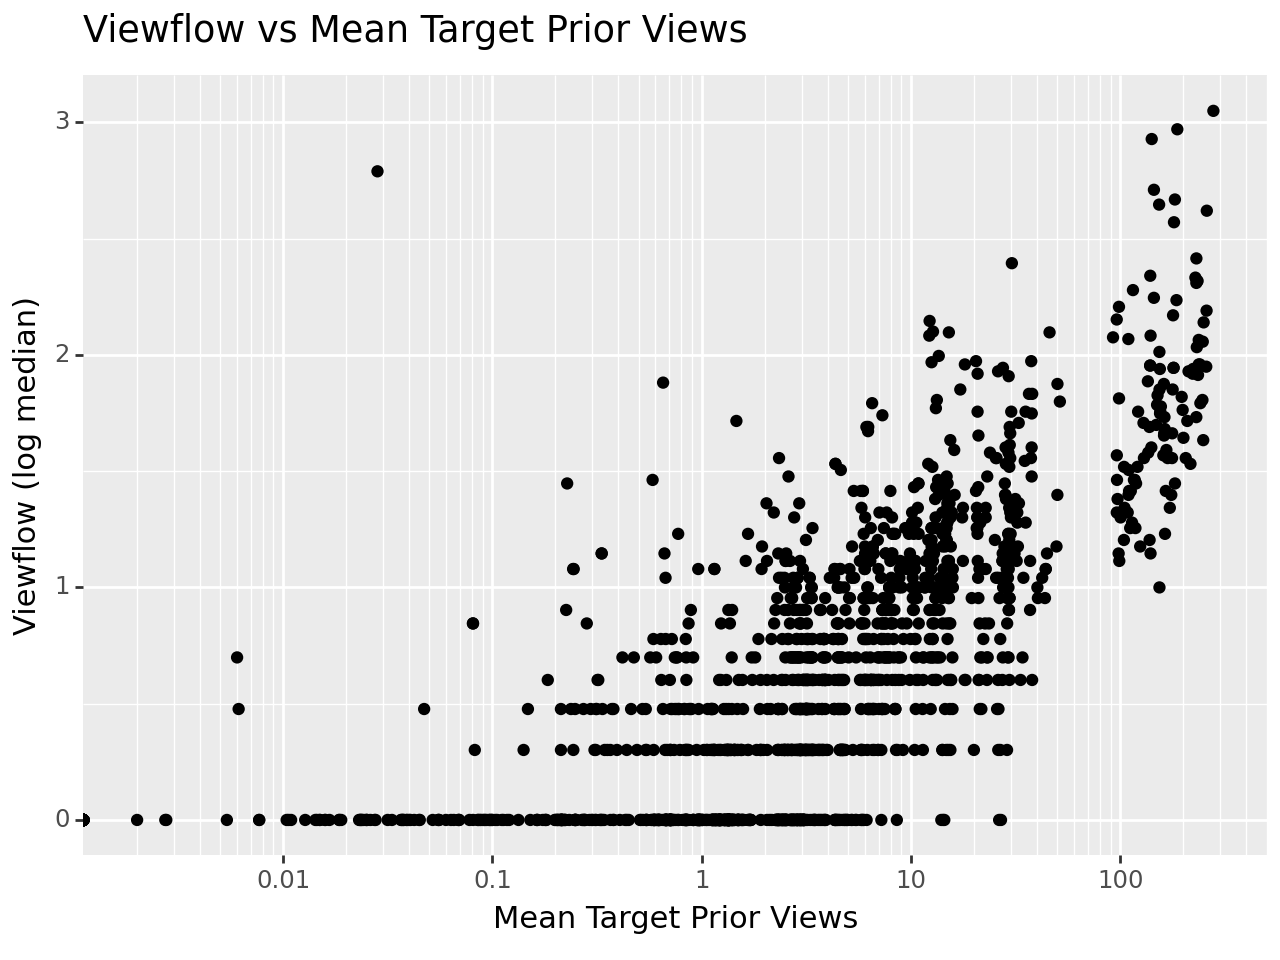

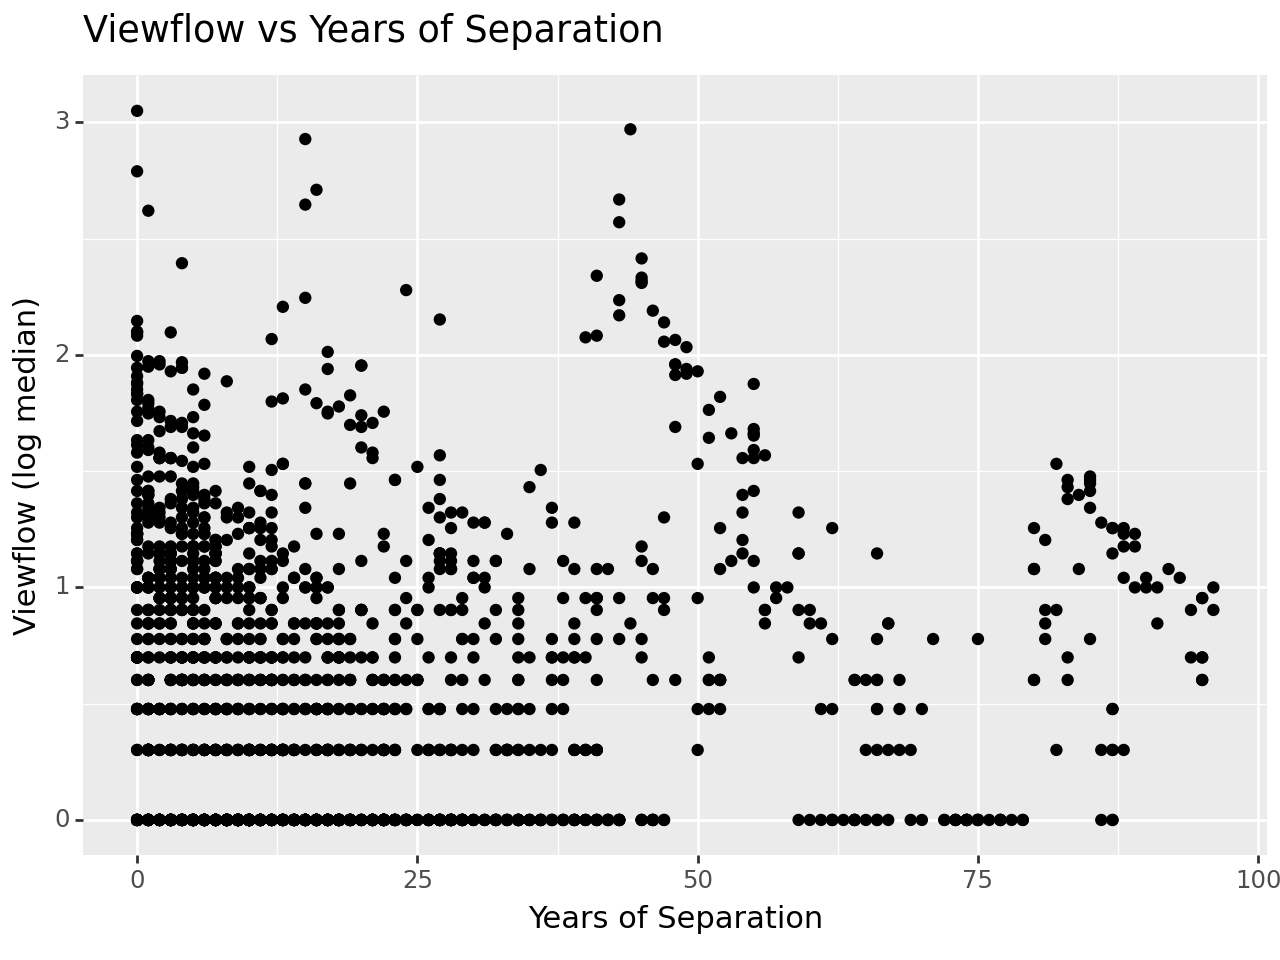

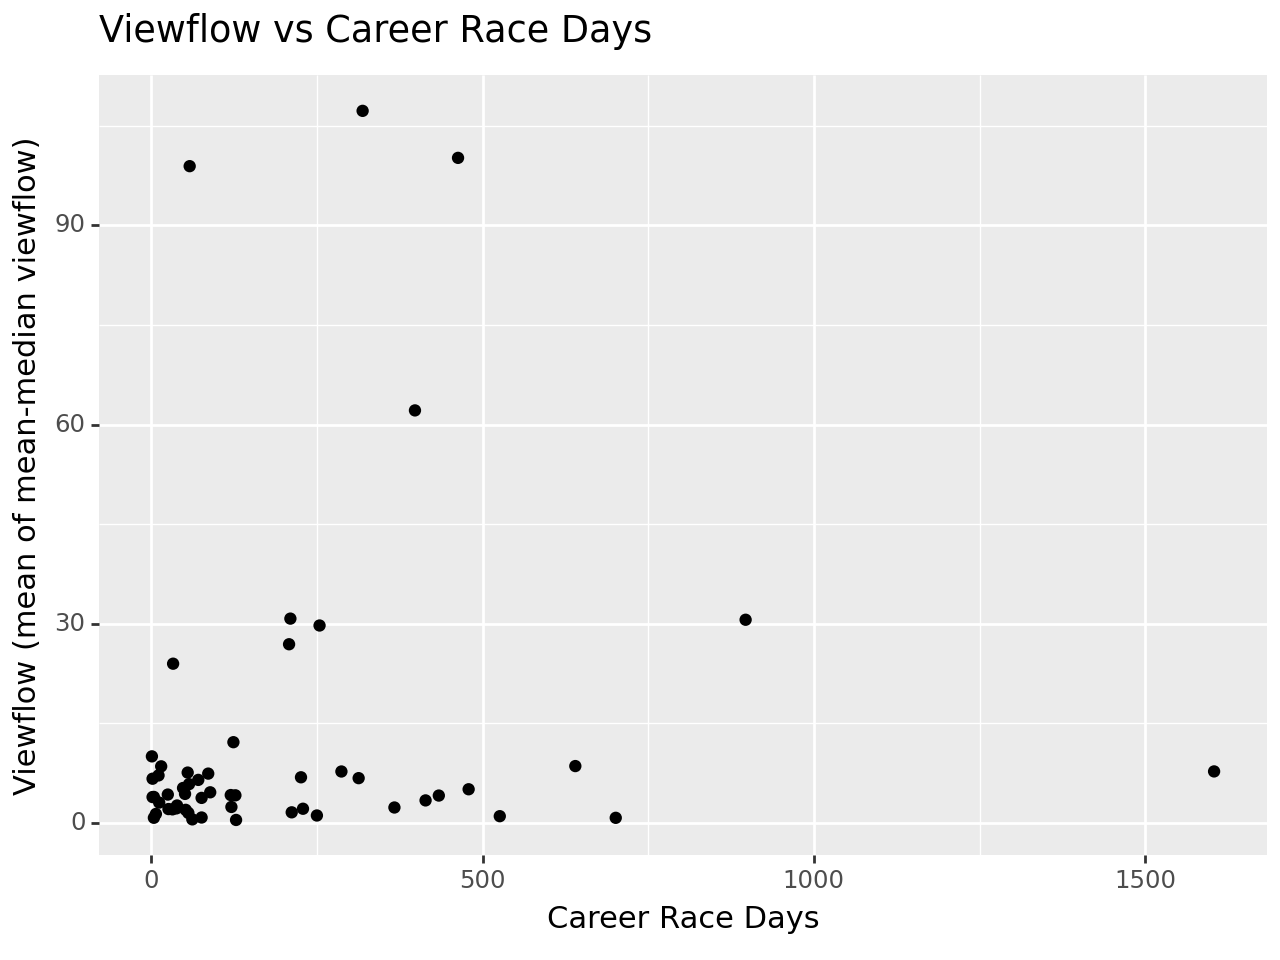

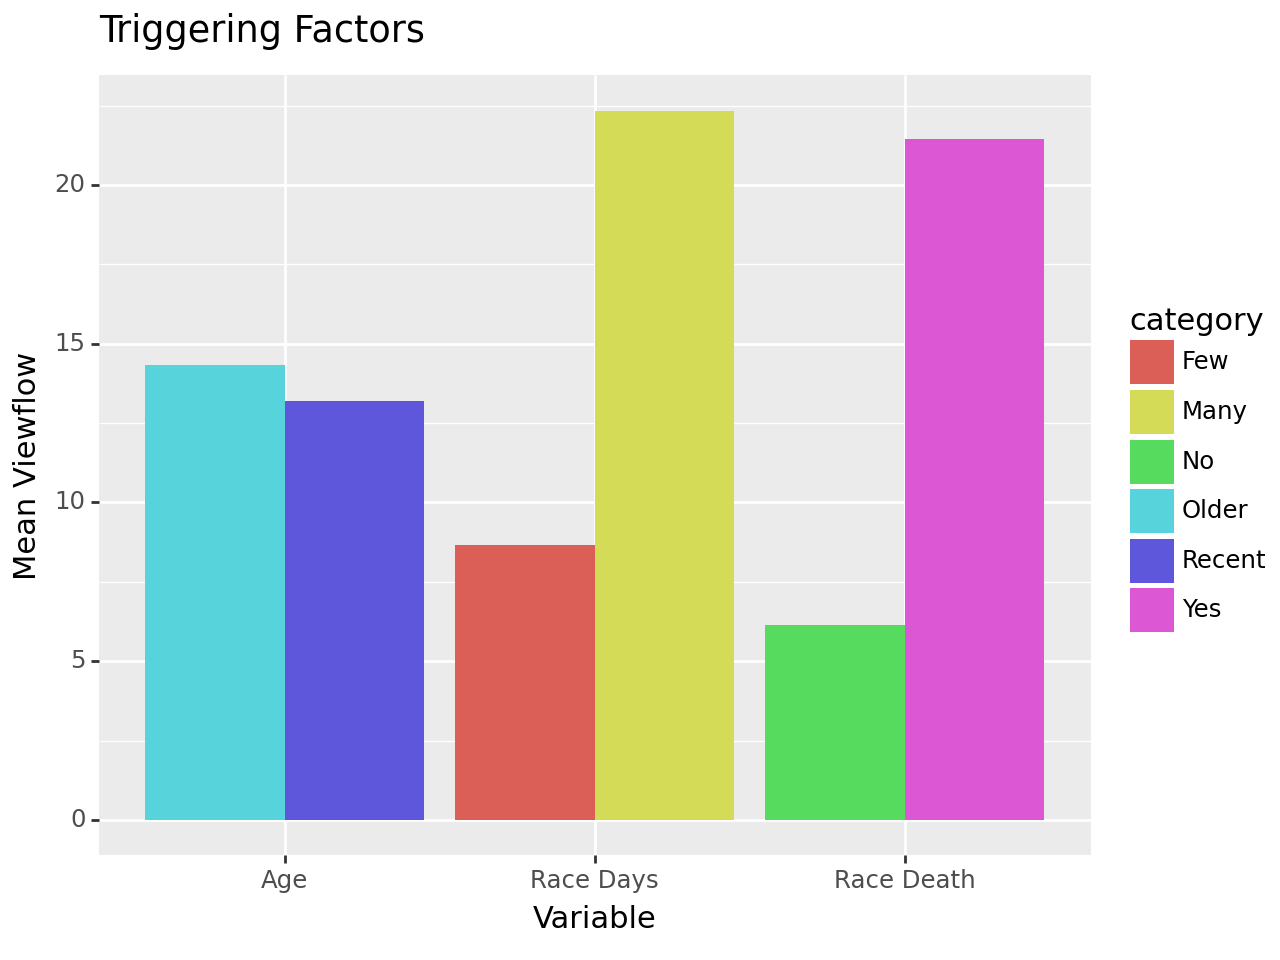


0    54.057360
1    53.248542
2    80.786788
3    37.406352
4    75.063929
5    13.535517
Name: standard_deviation, dtype: float64
206.27777777777777


In [128]:
cyclists = pd.read_csv('/home/ubuntu/Konstanz/SDMA/project/cyclists.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).drop_duplicates(subset=['Name'], keep='first')
viewflow_df = pd.read_csv('/home/ubuntu/Konstanz/SDMA/project/viewflow.csv',index_col=[0])
# find mean of viewflow for all targets
mean_grouped = viewflow_df.groupby('Target')['Viewflow_mean-median'].mean()
vf_cyclists = cyclists.merge(mean_grouped, left_on='Name', right_on='Target').rename(columns={"Viewflow_mean-median":"Av_VF"})
# adding missing info using wikipedia pages
additional_info = [{'Name': "Ottavio Bottecchia", 'Race death': 0}, 
                   {'Name': "Francisco Cepeda", 'Race death': 1}, 
                   {'Name': "Richard Depoorter", 'Race death': 1}, 
                   {'Name': "Stan Ockers", 'Race death': 1}, 
                   {'Name': "Tom Simpson", 'Race death': 1}, 
                   {'Name': "Jean-Pierre Monseré", 'Race death': 1}, 
                   {'Name': "Juan Manuel Santisteban", 'Race death': 1}, 
                   {'Name': "Vicente López Carril", 'Race death': 0}, 
                   {'Name': "Marc Demeyer", 'Race death': 0}, 
                   {'Name': "Bert Oosterbosch", 'Race death': 0}, 
                   {'Name': "Joachim Halupczok", 'Race death': 0}, 
                   {'Name': "Stive Vermaut", 'Race death': 0}, 
                   {'Name': "Rob Goris", 'Race death': 0}, 
                   {'Name': "Davide Rebellin", 'Race death': 0},
                   {'Name': "Arturo Gravalos", 'Race death': 0},
                   {'Name': "Ethan Boyes", 'Race death': 0},
                   {'Name': "Chris Anker Sørensen", 'Race death': 0},
                   {'Name': "Lieuwe Westra", 'Race death': 0},
                   {'Name': "Kelly Catlin", 'Race death': 0}]
additional_info_df = pd.DataFrame.from_dict(additional_info)
vf_cyclists = vf_cyclists.merge(additional_info_df, on='Name', how='outer')
# merge the info together
vf_cyclists['Race death_x'] = vf_cyclists['Race death_x'].fillna(vf_cyclists['Race death_y'])
vf_cyclists = vf_cyclists.rename(columns={'Race death_x':'Race death'})
vf_cyclists = vf_cyclists.drop(columns='Race death_y')

# 3 small plots to show some non-binary triggering factors
vf_race_days = (
    ggplot(vf_cyclists, aes(x='Career race days', y='Av_VF')) +
    geom_point() + 
    labs(title='Viewflow vs Career Race Days', x='Career Race Days', y='Viewflow (mean of mean-median viewflow)')
)

vf_years_sep = (
    ggplot(viewflow_df, aes(x='Years difference', y='Viewflow_log_median')) +
    geom_point() + 
    labs(title='Viewflow vs Years of Separation', x='Years of Separation', y='Viewflow (log median)')
)

vf_prior_views = (
    ggplot(viewflow_df, aes(x='Mean target prior views', y='Viewflow_log_median'))+ 
    geom_point() + 
    scale_x_log10() + 
    labs(title='Viewflow vs Mean Target Prior Views', x='Mean Target Prior Views', y='Viewflow (log median)')
)

# tons of calculations for binary triggering factors
mean_years_dif = viewflow_df['Years difference'].mean()
mean_race_days = vf_cyclists['Career race days'].mean()
viewflow_df = viewflow_df.merge(vf_cyclists[['Name', 'Career race days', 'Race death']], left_on='Target', right_on='Name')
mean_recent_vf = viewflow_df['Viewflow_median'][viewflow_df['Years difference'] <= mean_years_dif].mean()
mean_old_vf = viewflow_df['Viewflow_median'][viewflow_df['Years difference'] > mean_years_dif].mean()
mean_few_race_days_vf = viewflow_df['Viewflow_median'][viewflow_df['Career race days'] <= mean_race_days].mean() 
mean_many_race_days_vf = viewflow_df['Viewflow_median'][viewflow_df['Career race days'] > mean_race_days].mean()
mean_race_deaths_vf = viewflow_df['Viewflow_median'][viewflow_df['Race death'] == 1].mean()
mean_non_race_deaths_vf = viewflow_df['Viewflow_median'][viewflow_df['Race death'] == 0].mean()

std_recent_vf = viewflow_df['Viewflow_median'][viewflow_df['Years difference'] <= mean_years_dif].std()
std_old_vf = viewflow_df['Viewflow_median'][viewflow_df['Years difference'] > mean_years_dif].std()
std_few_race_days_vf = viewflow_df['Viewflow_median'][viewflow_df['Career race days'] <= mean_race_days].std() 
std_many_race_days_vf = viewflow_df['Viewflow_median'][viewflow_df['Career race days'] > mean_race_days].std()
std_race_deaths_vf = viewflow_df['Viewflow_median'][viewflow_df['Race death'] == 1].std()
std_non_race_deaths_vf = viewflow_df['Viewflow_median'][viewflow_df['Race death'] == 0].std()

vf_bar_chart_df = pd.DataFrame({'variable': ['Age', 'Age', 'Race Days', 'Race Days', 'Race Death', 'Race Death'],
                               'category':['Recent', 'Older', 'Many', 'Few', 'Yes', 'No'], 
                               'value':[mean_recent_vf, mean_old_vf, mean_many_race_days_vf, mean_few_race_days_vf, mean_race_deaths_vf, mean_non_race_deaths_vf],
                               'standard_deviation': [std_recent_vf, std_old_vf, std_many_race_days_vf, std_few_race_days_vf, std_race_deaths_vf, std_non_race_deaths_vf]})


triggering_factors_bar_chart = (
    ggplot(vf_bar_chart_df) +
    geom_col(aes(x='variable', y='value', fill='category'), position='dodge') + 
    labs(title='Triggering Factors', x='Variable', y='Mean Viewflow')
)
print(vf_prior_views)
print(vf_years_sep)
print(vf_race_days)
print(triggering_factors_bar_chart)